In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from deepcell_tracking.metrics import calculate_summary_stats

sns.set_style("whitegrid")

In [2]:
baxter_path = '../benchmarking/Baxter/ctc-benchmarks.csv'
# embedtrack_path = '../benchmarking/EmbedTrack/benchmarks.csv'
deepcell_path = '../benchmarking/Caliban/ctc-benchmarks.csv'
tracx_path = '../benchmarking/TracX/ctc-benchmarks.csv'
celltrackergnn_path = '../benchmarking/CellTrackerGNN/ctc-benchmarks.csv'

sum_columns = [
    'correct_division', 'mismatch_division',
    'false_positive_division', 'false_negative_division', 'total_divisions',
    'aa_tp', 'aa_total', 'te_tp', 'te_total']
mean_columns = ['DET', 'SEG', 'TRA']

stats_columns = ['Division F1', 'Mitotic branching correctness', 'Association Accuracy', 'Target Effectiveness', 'TRA']
labels = {
    'Division F1': 'Division\nF1',
    'Mitotic branching correctness': 'MBC',
    'Association Accuracy': 'AA',
    'Target Effectiveness': 'TE'
}

# Data Prep

In [3]:
paths = [deepcell_path, baxter_path, tracx_path, celltrackergnn_path]
dfs = []
for path in paths:
    sdf = pd.read_csv(path, index_col=0)

    # Rollup data for each model version
    sdf_a = sdf[['model'] + sum_columns].groupby('model').sum().reset_index()
    sdf_b = sdf[['model'] + mean_columns].groupby('model').mean().reset_index()
    sdf = sdf_a.merge(sdf_b, on='model')
    dfs.append(sdf)

df = pd.concat(dfs).set_index('model')

In [5]:
def calculate_stats(row):
    cols = ['correct_division', 'false_positive_division', 'false_negative_division', 'total_divisions',
            'aa_tp', 'aa_total', 'te_tp', 'te_total']
    d = row[cols].to_dict()
    return pd.Series(calculate_summary_stats(**d))

df = df.join(df.apply(calculate_stats, axis=1))

In [6]:
df

,correct_division,mismatch_division,false_positive_division,false_negative_division,total_divisions,aa_tp,aa_total,te_tp,te_total,DET,SEG,TRA,Division Recall,Division Precision,Division F1,Mitotic branching correctness,Fraction missed divisions,Association Accuracy,Target Effectiveness
model,,,,,,,,,,,,,,,,,,,
Caliban - Caliban,213,18,28,63,294,30553,30973,31469,31893,0.993703,0.896711,0.992827,0.77,0.88,0.82,0.70,0.21,0.99,0.99
Caliban - GT,226,16,26,52,294,30638,30973,31558,31893,1.000000,1.000000,0.999170,0.81,0.90,0.85,0.74,0.18,0.99,0.99
Baxter - Deepcell,212,3,46,79,294,30595,30973,31490,31893,0.991736,0.893586,0.990638,0.73,0.82,0.77,0.63,0.27,0.99,0.99
Baxter - GT,216,3,50,75,294,30396,30973,31261,31893,0.994415,0.993389,0.993416,0.74,0.81,0.78,0.63,0.26,0.98,0.98
TracX - Deepcell,23,36,29,235,294,30289,30973,31204,31893,0.993699,0.896698,0.990587,0.09,0.44,0.15,0.08,0.80,0.98,0.98
TracX - GT,19,35,23,240,294,30286,30973,31206,31893,1.000000,1.000000,0.996595,0.07,0.45,0.13,0.07,0.82,0.98,0.98
CellTrackerGNN Fluo-N2DL-HeLa - GT,219,52,358,23,294,29829,30973,30747,31893,0.998212,0.996328,0.995684,0.90,0.38,0.53,0.36,0.08,0.96,0.96
CellTrackerGNN Fluo-N2DL-HeLa - Pred,106,88,329,100,294,28444,30973,29232,31893,0.931132,0.846237,0.929476,0.51,0.24,0.33,0.20,0.34,0.92,0.92


In [6]:
# Restrict models with multiple candidates to their top performing candidate
top_embedtrack = 'Fluo-N2DL-HeLa'
top_celltrackergnn = 'Fluo-N2DL-HeLa'

drop_models = []
for m in df.index:
    if 'EmbedTrack' in m and top_embedtrack not in m:
        drop_models.append(m)
    if 'CellTrackerGNN' in m and top_celltrackergnn not in m:
        drop_models.append(m)

df = df.drop(index=drop_models).rename({
    f'CellTrackerGNN {top_celltrackergnn} - GT': 'CellTrackerGNN - GT',
    f'CellTrackerGNN {top_celltrackergnn} - Pred': 'CellTrackerGNN - CellTrackerGNN',
    f'EmbedTrack - {top_embedtrack}': 'EmbedTrack - EmbedTrack'
})

In [8]:
# Create new columns for tracking and segmentation models
df = df.reset_index()
df[['tracking', 'segmentation']] = df['model'].str.split(' - ', expand=True)

# Add empty missing value for GT EmbedTrack benchmarking
df = df._append({'model': 'EmbedTrack - GT', 'tracking': 'EmbedTrack', 'segmentation': 'GT'}, ignore_index=True).fillna(0.000001)

In [8]:
df[[ 'DET', 'SEG', 'TRA', 'Division Recall', 'Division Precision', 'Division F1', 'Mitotic branching correctness', 'Association Accuracy', 'Target Effectiveness']]

,DET,SEG,TRA,Division Recall,Division Precision,Division F1,Mitotic branching correctness,Association Accuracy,Target Effectiveness
model,,,,,,,,,
Caliban - Caliban,0.993703,0.896711,0.992827,0.77,0.88,0.82,0.70,0.99,0.99
Caliban - GT,1.000000,1.000000,0.999170,0.81,0.90,0.85,0.74,0.99,0.99
Baxter - Deepcell,0.991736,0.893586,0.990638,0.73,0.82,0.77,0.63,0.99,0.99
Baxter - GT,0.994415,0.993389,0.993416,0.74,0.81,0.78,0.63,0.98,0.98
TracX - Deepcell,0.993699,0.896698,0.990587,0.09,0.44,0.15,0.08,0.98,0.98
TracX - GT,1.000000,1.000000,0.996595,0.07,0.45,0.13,0.07,0.98,0.98
CellTrackerGNN Fluo-N2DL-HeLa - GT,0.998212,0.996328,0.995684,0.90,0.38,0.53,0.36,0.96,0.96
CellTrackerGNN Fluo-N2DL-HeLa - Pred,0.931132,0.846237,0.929476,0.51,0.24,0.33,0.20,0.92,0.92


In [10]:
plot_df = df.melt(
    id_vars=['model', 'tracking', 'segmentation'],
    value_vars=stats_columns,
    var_name='metric'
    )

# Merge to put one tracking model per row
plot_df = plot_df[plot_df['segmentation'] == 'GT'].merge(plot_df[plot_df['segmentation'] != 'GT'],
                                                         on=['tracking', 'metric'],
                                                         suffixes=['_gt', '_pred'])
plot_df = plot_df.replace(labels)

# Plotting

/var/folders/bd/bn434f8n1bsdd8y0yby_fv7r0000gn/T/ipykernel_58113/3654433174.py:3: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.barplot(
/var/folders/bd/bn434f8n1bsdd8y0yby_fv7r0000gn/T/ipykernel_58113/3654433174.py:10: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.barplot(


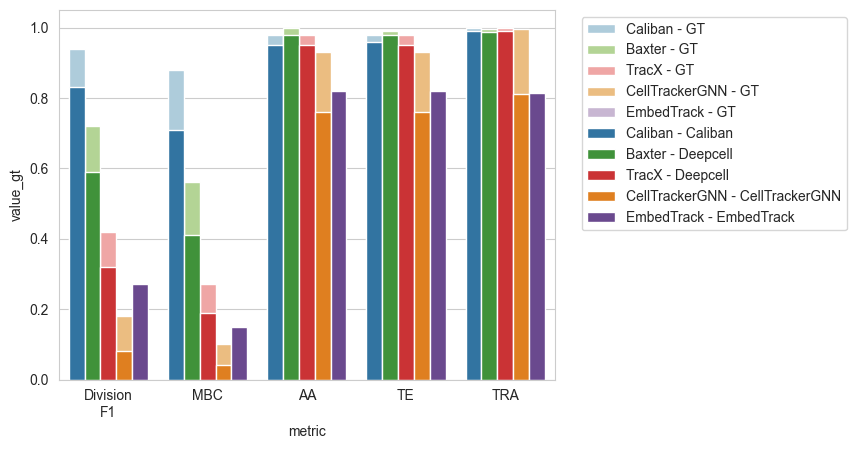

In [11]:
fig, ax = plt.subplots()

sns.barplot(
    data=plot_df,
    x='metric',
    y='value_gt',
    hue='model_gt',
    palette=sns.color_palette("Paired")[::2]
)
sns.barplot(
    data=plot_df,
    x='metric',
    y='value_pred',
    hue='model_pred',
    palette=sns.color_palette("Paired")[1::2]
)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
fig.savefig('benchmarking.pdf')

In [12]:
plot_df

,model_gt,tracking,segmentation_gt,metric,value_gt,model_pred,segmentation_pred,value_pred
0,Caliban - GT,Caliban,GT,Division\nF1,0.940000,Caliban - Caliban,Caliban,0.830000
1,Baxter - GT,Baxter,GT,Division\nF1,0.720000,Baxter - Deepcell,Deepcell,0.590000
2,TracX - GT,TracX,GT,Division\nF1,0.420000,TracX - Deepcell,Deepcell,0.320000
3,CellTrackerGNN - GT,CellTrackerGNN,GT,Division\nF1,0.180000,CellTrackerGNN - CellTrackerGNN,CellTrackerGNN,0.080000
4,EmbedTrack - GT,EmbedTrack,GT,Division\nF1,0.000001,EmbedTrack - EmbedTrack,EmbedTrack,0.270000
5,Caliban - GT,Caliban,GT,MBC,0.880000,Caliban - Caliban,Caliban,0.710000
6,Baxter - GT,Baxter,GT,MBC,0.560000,Baxter - Deepcell,Deepcell,0.410000
7,TracX - GT,TracX,GT,MBC,0.270000,TracX - Deepcell,Deepcell,0.190000
8,CellTrackerGNN - GT,CellTrackerGNN,GT,MBC,0.100000,CellTrackerGNN - CellTrackerGNN,CellTrackerGNN,0.040000
9,EmbedTrack - GT,EmbedTrack,GT,MBC,0.000001,EmbedTrack - EmbedTrack,EmbedTrack,0.150000
